<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Unsupervised_Learning/Example_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score

In [2]:
# K-means clustering
x, y = make_blobs(n_samples=100, centers=4, n_features=2, cluster_std=[1, 1.5, 2, 2], random_state=7)
df_blobs = pd.DataFrame({
    'x1': x[:,0], 'x2': x[:,1], 'y': y
})

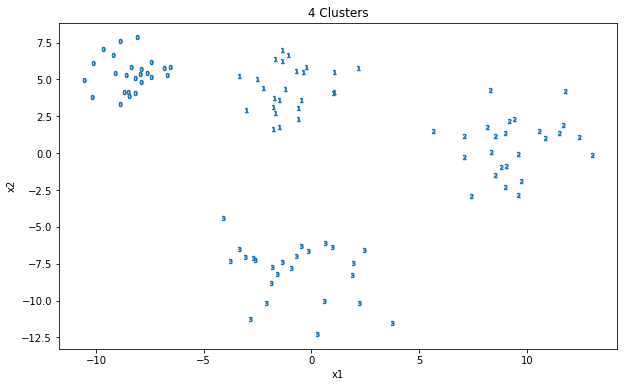

In [15]:
# Visualizing sample data
def plot_2d_clusters(x, y, ax):
  y_uniques = pd.Series(y).unique()
  for y_unique_item in y_uniques:
    x[y==y_unique_item].plot(title=f'{len(y_uniques)} Clusters',
                             kind='scatter', x='x1', y='x2',
                             marker=f'${y_unique_item}$', ax=ax)
    
fig, ax = plt.subplots(1,1,figsize=(10,6))
x, y = df_blobs[['x1','x2']], df_blobs['y']
plot_2d_clusters(x, y, ax)

Text(0.5, 1.0, 'KMeans: 5 Clusters')

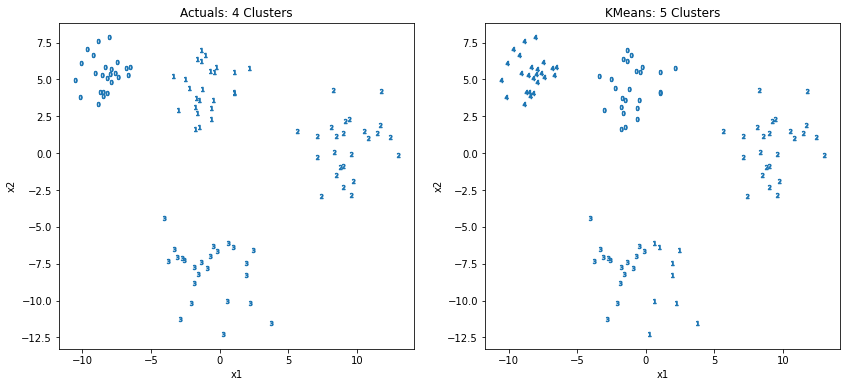

In [15]:
kmeans = KMeans(n_clusters=5, random_state=7)
x, y = df_blobs[['x1', 'x2']], df_blobs['y']
y_pred = kmeans.fit_predict(x)

fig, axs = plt.subplots(1,2,figsize=(14, 6))
plot_2d_clusters(x, y, axs[0])
plot_2d_clusters(x, y_pred, axs[1])

axs[0].set_title(f'Actuals: {axs[0].get_title()}')
axs[1].set_title(f'KMeans: {axs[1].get_title()}')

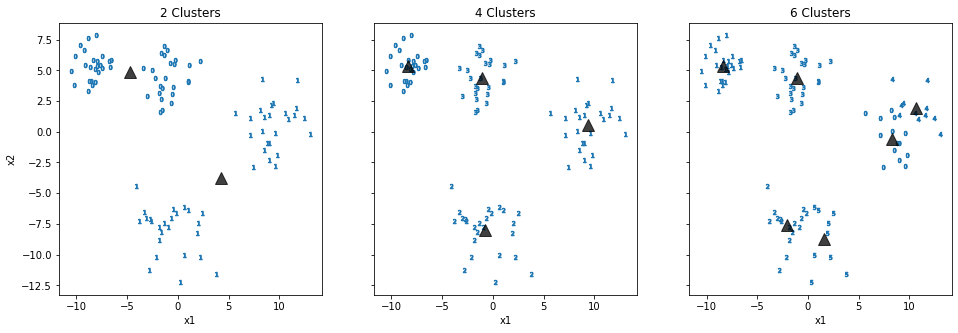

In [20]:
# Trying different numbers of clusters
n_clusters_options = [2,4,6]

fig, axs = plt.subplots(1, len(n_clusters_options), figsize=(16,5), sharey=True)

for i, n_clusters in enumerate(n_clusters_options):
  kmeans = KMeans(n_clusters=n_clusters, random_state=7)
  y_pred = kmeans.fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^', ms=12, alpha=0.75)

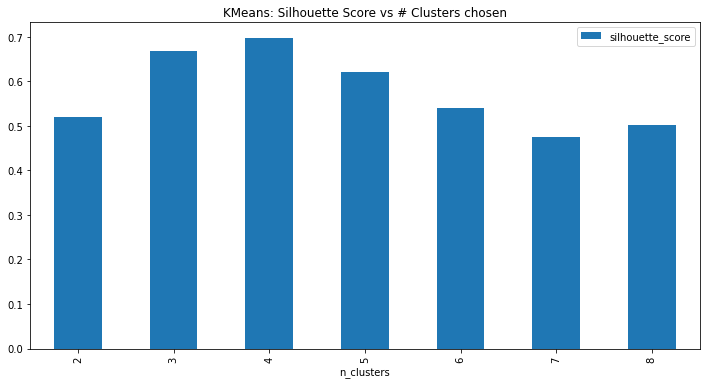

In [22]:
# Calculating the Silhouette score
n_clusters_options = [2,3,4,5,6,7,8]
silhouette_scores = []

for i, n_clusters in enumerate(n_clusters_options):
  kmeans = KMeans(n_clusters=n_clusters, random_state=7)
  y_pred = kmeans.fit_predict(x)
  silhouette_scores.append(silhouette_score(x, y_pred))

fig, ax = plt.subplots(1,1,figsize=(12,6))

pd.DataFrame({
    'n_clusters': n_clusters_options,
    'silhouette_score':  silhouette_scores
}).set_index('n_clusters').plot(title='KMeans: Silhouette Score vs # Clusters chosen',
                                kind='bar', ax=ax)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


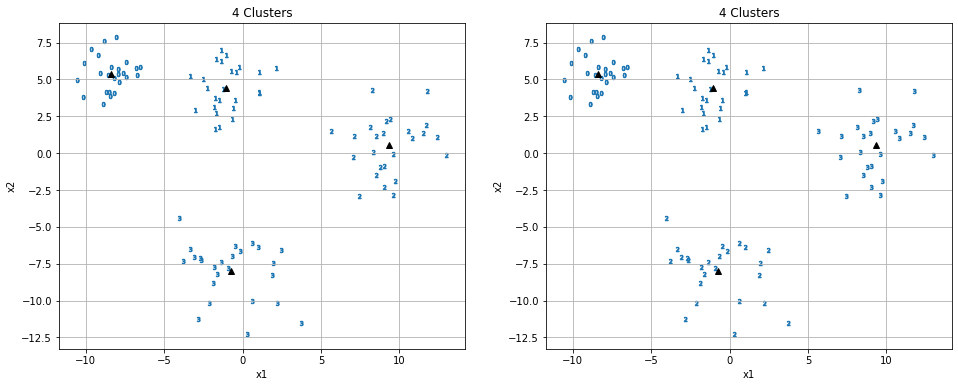

In [6]:
# Choosing initial centroids
initial_centroids_options = np.array([
    [(-10,5), (0,5), (10,0), (-10,0)], [(0,0), (0.1,0.1), (0,0), (0.1,0.1)]                                  
])

fig, axs = plt.subplots(1,2,figsize=(16,6))
for i, initial_centroids in enumerate(initial_centroids_options):
  kmeans = KMeans(init=initial_centroids, max_iter=500, n_clusters=4, random_state=7)
  y_pred = kmeans.fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 'k^')
  axs[i].grid()

In [3]:
# Agglomerative clustering
x, y = df_blobs[['x1', 'x2']], df_blobs['y']

agglo = AgglomerativeClustering(n_clusters=4)
y_pred = agglo.fit_predict(x)
agglo.children_[-5:]

array([[182, 193],
       [188, 192],
       [189, 191],
       [194, 195],
       [196, 197]])

In [8]:
def get_children(node, n_samples):
  if node[0] >= n_samples:
    child_cluster_id = node[0] - n_samples
    left = get_children(agglo.children_[child_cluster_id], n_samples)
  else:
    left = node[0]
  if node[1] >= n_samples:
    child_cluster_id = node[1] - n_samples
    right = get_children(agglo.children_[child_cluster_id], n_samples)
  else:
    right = node[1]
  return [left, right]

def flatten(sub_tree, flat_list):
  if type(sub_tree) is not list:
    flat_list.append(sub_tree)
  else:
    r, l = sub_tree
    flatten(r, flat_list)
    flatten(l, flat_list)

In [9]:
root = agglo.children_[-1]
n_samples = df_blobs.shape[0]
tree = get_children(root, n_samples)
flat_list = []
flatten(tree[0][0], flat_list)
print(flat_list)

[46, 25, 73, 21, 66, 87, 88, 22, 64, 4, 49, 98, 19, 55, 72, 37, 70, 47, 82, 13, 39, 92, 2, 8, 35]


In [10]:
# build our own predicted labels
n_samples = x.shape[0]
y_pred_dash = np.zeros(n_samples)
for i, j, label in [(0,0,0), (0,1,1), (1,0,2), (1,1,3)]:
  flat_list = []
  flatten(tree[i][j], flat_list)
  for sample_index in flat_list:
    y_pred_dash[sample_index] = label

In [13]:
# The adjusted Rand index
print("Adjusted Rand Index: ", adjusted_rand_score(y_pred, y_pred_dash))

Adjusted Rand Index:  1.0


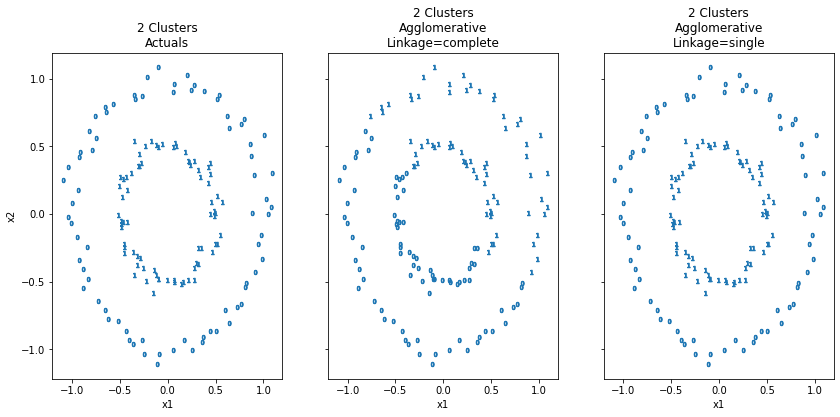

In [26]:
# Choosing the cluster linkage
x, y = make_circles(n_samples=150, factor=0.5, noise=0.05, random_state=7)
df_circles = pd.DataFrame({'x1': x[:,0], 'x2': x[:,1], 'y': y})

linkage_options = ['complete', 'single']

fig, axs = plt.subplots(1, len(linkage_options)+1, figsize=(14,6), sharey=True)

x, y = df_circles[['x1' ,'x2']], df_circles['y']

plot_2d_clusters(x, y, axs[0])
axs[0].set_title(f'{axs[0].get_title()}\nActuals')

for i, linkage in enumerate(linkage_options, 1):
  y_pred = AgglomerativeClustering(n_clusters=2, affinity='manhattan',
                                   linkage=linkage).fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].set_title(f'{axs[i].get_title()}\nAgglomerative\nLinkage={linkage}')


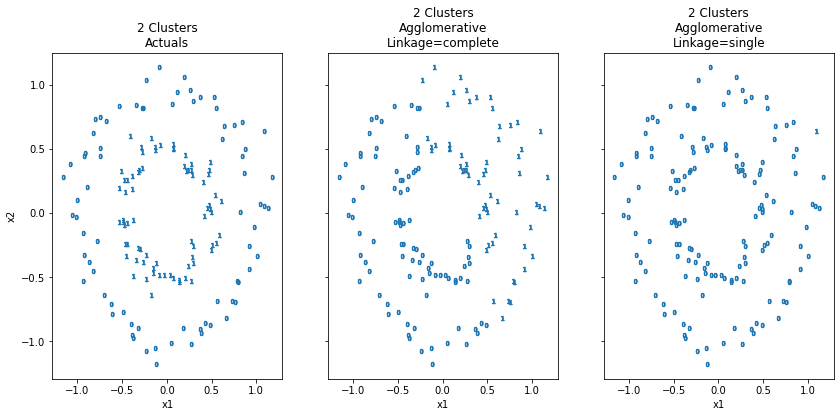

In [25]:
# Effect of higher noise level
x, y = make_circles(n_samples=150, factor=0.5, noise=0.08, random_state=7)
df_circles = pd.DataFrame({'x1': x[:,0], 'x2': x[:,1], 'y': y})

linkage_options = ['complete', 'single']

fig, axs = plt.subplots(1, len(linkage_options)+1, figsize=(14,6), sharey=True)

x, y = df_circles[['x1' ,'x2']], df_circles['y']

plot_2d_clusters(x, y, axs[0])
axs[0].set_title(f'{axs[0].get_title()}\nActuals')

for i, linkage in enumerate(linkage_options, 1):
  y_pred = AgglomerativeClustering(n_clusters=2, affinity='manhattan',
                                   linkage=linkage).fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].set_title(f'{axs[i].get_title()}\nAgglomerative\nLinkage={linkage}')

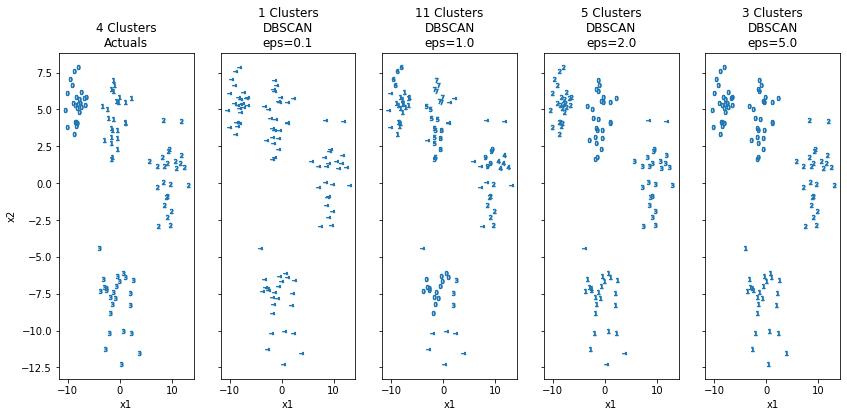

In [24]:
# Density-based Spatial Clustering of Applications with Noise
# (DBSCAN)
eps_options = [0.1, 1.0, 2.0, 5.0]

fig, axs = plt.subplots(1, len(eps_options)+1, figsize=(14,6), sharey=True)

x, y = df_blobs[['x1', 'x2']], df_blobs['y']

plot_2d_clusters(x, y, axs[0])
axs[0].set_title(f'{axs[0].get_title()}\nActuals')

for i, eps in enumerate(eps_options, 1):
  y_pred = DBSCAN(eps=eps, min_samples=3, metric='euclidean').fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].set_title(f'{axs[i].get_title()}\nDBSCAN\neps={eps}')

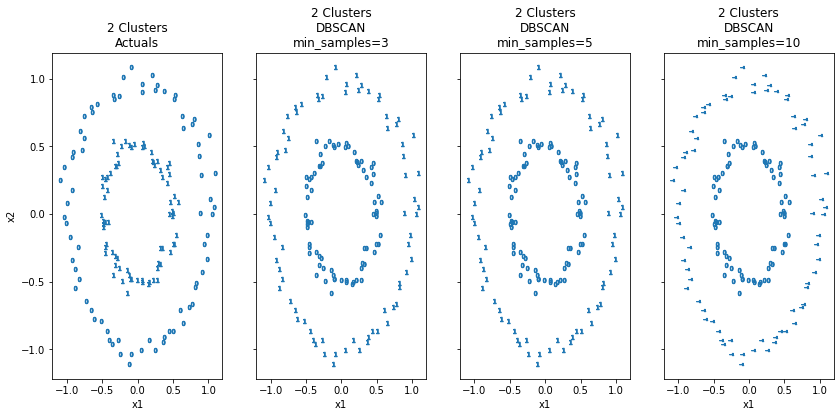

In [27]:
# Effect of minimum sample size on DBSCAN
min_samples_options = [3, 5, 10]

fig, axs = plt.subplots(1, len(min_samples_options)+1, figsize=(14,6), sharey=True)

x, y = df_circles[['x1', 'x2']], df_circles['y']

plot_2d_clusters(x, y, axs[0])
axs[0].set_title(f'{axs[0].get_title()}\nActuals')

for i, min_samples in enumerate(min_samples_options, 1):
  y_pred = DBSCAN(eps=0.25, min_samples=min_samples, metric='euclidean',
                  n_jobs=-1).fit_predict(x)
  plot_2d_clusters(x, y_pred, axs[i])
  axs[i].set_title(f'{axs[i].get_title()}\nDBSCAN\nmin_samples={min_samples}')

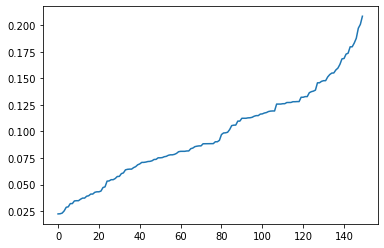

In [29]:
x = df_circles[['x1', 'x2']]
distances, _ = NearestNeighbors(n_neighbors=2).fit(x).kneighbors()
pd.Series(distances[:,-1]).sort_values().reset_index(drop=True).plot()